In [24]:
# %env DRJIT_LIBLLVM_PATH /usr/lib/x86_64-linux-gnu/libLLVM-15.0.7.so.1
# !echo $DRJIT_LIBLLVM_PATH

In [25]:
# %%bash
# ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6 ${CONDA_PREFIX}/lib/libstdc++.so.6
# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

In [26]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')

import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
import time

mi.set_variant('cuda_ad_rgb')
# mi.set_variant('llvm_ad_rgb')

In [27]:
from furnace_scene import make_scene_disney, visualize_scene
import numpy as np

color_ref = [0.2, 0.25, 0.7]
roughness = 0.3
scene = make_scene_disney(color_ref, roughness)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24867778..4.637867].


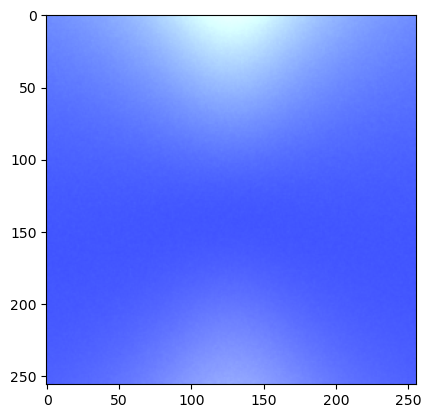

In [28]:
image = mi.render(scene)

import matplotlib.pyplot as plt
plt.imshow(image)

In [29]:
from radiosity_rt import SceneSurfaceSampler, RadianceCacheMITSUBA, compute_loss

NUM_WI_DIRECTIONS = 256 << 2 # 32
SAMPLES_PER_RAY_LI = 64 # 32
SAMPLES_PER_RAY_LO = 256 # 128
NUM_GEO_SAMPLES = 1024 # 128

scene_sampler = SceneSurfaceSampler(scene)
radiance_cache = RadianceCacheMITSUBA(scene, 
                                      spp_per_wo=SAMPLES_PER_RAY_LO, 
                                      spp_per_wi=SAMPLES_PER_RAY_LI)


In [30]:
from train import define_BSDF_principled_uniform

# Initialize BSDF to train
bsdf_train, keys = define_BSDF_principled_uniform()
params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
for key in keys:
    dr.enable_grad(params[key])
    opt[key] = params[key]
    params.update(opt)

losses = []
for it in range(100):
    time1 = time.time()

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, radiance_cache, bsdf_train, 
        NUM_GEO_SAMPLES, NUM_WI_DIRECTIONS, it)

    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    for key in keys:
        # Post-process the optimized parameters to ensure legal color values.
        opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    losses.append(loss.numpy())
    time2 = time.time()
    # print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}")

Iteration 001 [1.177595]: Loss = [0.467192]
Iteration 002 [1.122264]: Loss = [0.273499]
Iteration 003 [0.407417]: Loss = [0.156869]
Iteration 004 [0.408753]: Loss = [0.0745774]
Iteration 005 [0.410436]: Loss = [0.0518643]
Iteration 006 [0.407041]: Loss = [0.0431604]
Iteration 007 [0.410594]: Loss = [0.0593727]
Iteration 008 [0.408887]: Loss = [0.0782935]
Iteration 009 [0.411670]: Loss = [0.0913861]
Iteration 010 [0.410162]: Loss = [0.104686]
Iteration 011 [0.409405]: Loss = [0.0974626]
Iteration 012 [0.411022]: Loss = [0.0803419]
Iteration 013 [0.406578]: Loss = [0.0598501]
Iteration 014 [0.410753]: Loss = [0.0517103]
Iteration 015 [0.409985]: Loss = [0.0537606]
Iteration 016 [0.409986]: Loss = [0.0385889]
Iteration 017 [0.411362]: Loss = [0.0368453]
Iteration 018 [0.409080]: Loss = [0.0464021]
Iteration 019 [0.410491]: Loss = [0.04792]
Iteration 020 [0.409739]: Loss = [0.0435431]
Iteration 021 [0.409954]: Loss = [0.0460832]
Iteration 022 [0.410785]: Loss = [0.0536013]
Iteration 023 [0

In [31]:
# opt
params["roughness.value"]

[0.316615]

['base_color.value', 'roughness.value']
Reference albedo: [0.2, 0.25, 0.7],	Reference roughness: 0.3
Optimized albedo: [[0.203232, 0.25062, 0.681912]],	optimized roughness: [0.316615]


Text(0, 0.5, 'Loss')

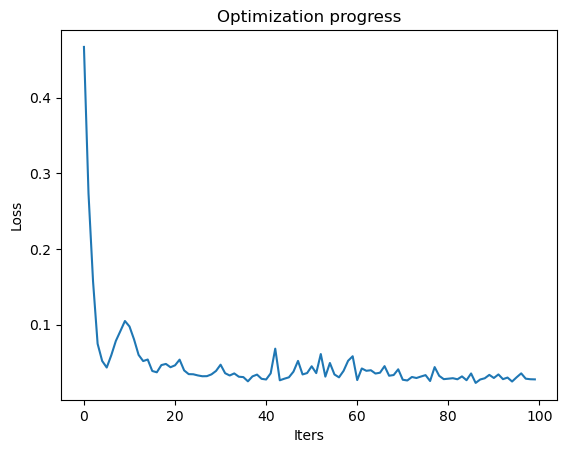

In [32]:
import matplotlib.pyplot as plt


print(keys)
print(f"Reference albedo: {color_ref},\tReference roughness: {roughness}")
color_opt = params["base_color.value"]
alpha_opt = params["roughness.value"]
print(f"Optimized albedo: {color_opt},\toptimized roughness: {alpha_opt}")

plt.figure()
plt.title("Optimization progress")
plt.plot(np.array(losses))
plt.xlabel("Iters")
plt.ylabel("Loss")